# Centróides Brasil  

### *Dados padronizados

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/centroides_brasil.ipynb`

## Bibliotecas

In [1]:
#!pip install geopandas==0.8.1
#!pip install --upgrade pyshp
#!pip install shapely==1.7.0
#!pip install --upgrade descartes
#!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
#!pip install esda

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style='whitegrid', palette='pastel') 

# para a análise de componentes principais
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, AgglomerativeClustering

# para avaliar grupos 
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix


## Dados

https://www.gov.br/agricultura/pt-br/assuntos/riscos-seguro/seguro-rural/relatorios-estatisticos

In [3]:
link = 'https://raw.githubusercontent.com/walefmachado/spatial_cluster/master/data/'

In [4]:
# função para deixar todos os nomes de municípios iguais (sem acento, sem espaço)
def simplificar_nomes(df, variavel):
  df[variavel] = (df[variavel].str.strip()
                 .str.lower()
                 .str.replace(' ', '_')
                 .str.replace('\'', '')
                 .str.replace('-','_')
                 .str.replace('á', 'a')
                 .str.replace('é', 'e')
                 .str.replace('í', 'i')
                 .str.replace('ó', 'o')
                 .str.replace('ú', 'u')
                 .str.replace('â', 'a')
                 .str.replace('ê', 'e')
                 .str.replace('ô', 'o')
                 .str.replace('í', 'i')
                 .str.replace('ã','a')
                 .str.replace('õ','o')
                 .str.replace('ç','c')
                 .str.replace('à', 'a')
                 .str.replace('ü', 'u'))

### Dados de seguro rural

In [5]:
dados18 = pd.read_csv(link+'/seguro18.csv', encoding='utf-8')
dados18.head()

,ano,uf,nome_mun,cultura,seguradora,evento_sinistro,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas
0,2018,AC,Rio Branco,Pecuário,Mapfre,-,2,988246.80,9892.13,4451.45,0.00,0.0,0.01,0
1,2018,AL,Igaci,Milho 1ª safra,Aliança do Brasil,SECA,1,646644.90,51309.86,23089.44,514018.03,10018.0,79.00,1
2,2018,AL,Limoeiro de Anadia,Milho 1ª safra,Sancor,-,1,322882.69,29059.47,13076.76,0.00,0.0,0.09,0
3,2018,AL,Messias,Pecuário,Mapfre,-,1,386600.00,3869.78,1741.40,0.00,0.0,0.01,0
4,2018,AL,Santana do Mundaú,Pecuário,Mapfre,-,1,165920.00,1660.82,747.36,0.00,0.0,0.01,0


In [6]:
dados = dados18
cod = pd.read_csv(link+'/codigos-mun.csv')
cod = cod[['mun', 'nome_mun', 'nome_meso']]
cod.shape

(5570, 3)

In [7]:
# simplificar os nomes dos municípios nos dois dataframes
simplificar_nomes(cod, 'nome_mun')
simplificar_nomes(dados, 'nome_mun')

In [8]:
dados = dados.merge(cod, on='nome_mun', how='left')
dados.shape

(15395, 16)

In [9]:
dados = dados.drop('ano', axis=1).groupby('mun').sum()

In [10]:
dados.reset_index(level = 0, inplace = True)

In [11]:
dados.shape

(2293, 9)

In [12]:
dados = dados.merge(cod, on='mun')

In [13]:
dados.head()

,mun,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,nome_mun,nome_meso
0,1100023.0,1,2300000.00,18456.81,8305.56,0.00,0.0,8.00,0,ariquemes,Leste Rondoniense
1,1100056.0,2,195143.31,10732.87,4829.80,0.00,0.0,55.00,0,cerejeiras,Leste Rondoniense
2,1100072.0,2,2548975.13,222758.25,89103.30,0.00,0.0,87.00,0,corumbiara,Leste Rondoniense
3,1100130.0,1,153645.48,9218.72,4148.42,0.00,0.0,0.06,0,machadinho_doeste,Leste Rondoniense
4,1100403.0,2,154950.18,9028.44,4062.80,39291.79,4352.0,58.00,2,alto_paraiso,Leste Rondoniense


In [14]:
# retirar = ['sinistralidade_media', 'taxa_media']
# dados = dados.drop(retirar, axis=1)
# dados.head()

In [15]:
seguro = dados # não sei porque fiz isso.. rs 

### Dados para espacial 

In [16]:
# seguro = pd.read_csv(link_p+'seguroagricola2017.csv', encoding='latin1') # troquei para 2018
cod = pd.read_csv(link+'cod-nome-corrigido.csv', encoding='latin1')

br = geopandas.read_file(link+'br.json')
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [17]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [18]:
# apolices = seguro.groupby('nome_mun').apolices_contratadas.sum()
# apolices = pd.DataFrame(apolices).reset_index()

In [19]:
dados_br = cod_dados.merge(seguro, how='left')

In [20]:
dados_br = dados_br.fillna(0)
dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['Unnamed: 0', 'rm'], axis = 1)

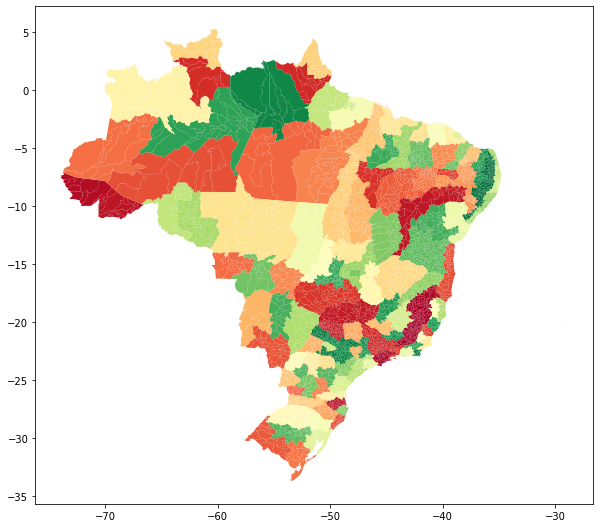

In [21]:
# dados_br.plot(column='apolices', figsize=(10, 10), scheme='quantiles', cmap='OrRd', legend=True, k=4);
dados_br.plot(column='nome_meso', figsize=(10, 10), cmap='RdYlGn_r'); # , cmap='OrRd',  cmap='plasma'

## Centroides




In [22]:
dados_br.geometry.centroid.x

dados_br['x_centroid'] = dados_br.geometry.centroid.x
dados_br['y_centroid'] = dados_br.geometry.centroid.y

/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/home/walef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [23]:
dados_centroids = dados_br
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao'] # 
dados_centroids = dados_centroids.drop(retirar, axis = 1)

## Análise de agrupamento - Centroides

In [45]:
# subselecionar variáveis
XX = scale(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))# transformar em matriz (necessário para gerar o gráfico)
# mudar o tipo dos dados
X = np.asarray(XX, dtype=float)
n = X.shape[0]
p = X.shape[1]
# vetor de médias
Xb = np.mean(X, axis=0)
# matriz de covariâncias
S = np.cov(X.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [46]:
Z = linkage(X, method='ward')

In [47]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

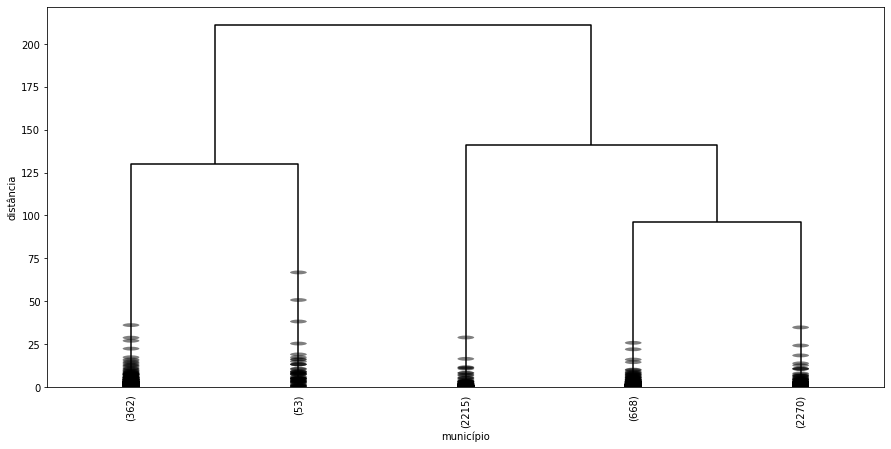

In [48]:
fig, ax = plt.subplots(figsize=(15, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município')
plt.ylabel('distância');

Método escolhido:

In [49]:
## definir a distância de corte baseando no dendrograma
max_d = 75
grupos = cut_tree(Z, height=max_d)

### Métricas

In [50]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

2938.9 0.92 0.53


In [51]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = grupos
# moran_matrix.head(2)

In [52]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    2270
3    2215
1     668
2     362
4      53
Name: grupo, dtype: int64

In [53]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,1.884141,2.689711e+05,1.524299e+04,6.601908e+03,1.000012e+04,695.471753,60.278753,0.265198,-49.459377,-21.617643,0.000881
1,21.025449,5.853185e+06,3.254961e+05,1.369017e+05,1.973343e+05,4589.302515,352.350299,2.818862,-49.947570,-20.828967,6.181138
2,97.091160,1.698500e+07,1.219657e+06,5.276842e+05,1.425443e+06,26810.362624,1486.579503,29.226519,-50.872556,-22.435052,4.000000
3,0.211738,4.360711e+04,2.632710e+03,1.173326e+03,4.627400e+03,127.103688,5.795418,0.026185,-40.976691,-8.705262,0.000000
4,333.773585,6.436414e+07,5.213385e+06,2.226526e+06,6.766124e+06,47826.673208,2282.101321,128.000000,-51.077409,-23.040795,3.641509


In [54]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,0.0,0.000000e+00,0.000,0.000,0.00,0.000,0.000,0.0,-49.285678,-21.761798,0
1,16.0,4.192120e+06,244663.235,103573.670,48027.81,2255.500,279.125,1.0,-50.222965,-21.804794,7
2,79.5,1.410209e+07,1047143.420,450102.395,1073940.30,24400.585,1449.360,21.0,-51.537074,-23.466372,5
3,0.0,0.000000e+00,0.000,0.000,0.00,0.000,0.000,0.0,-40.313897,-7.679992,0
4,317.0,5.360152e+07,4280000.750,1846939.520,5502523.96,47141.370,1967.180,93.0,-51.461810,-23.759737,4


### As observações de cada grupo

In [55]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroides

In [56]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

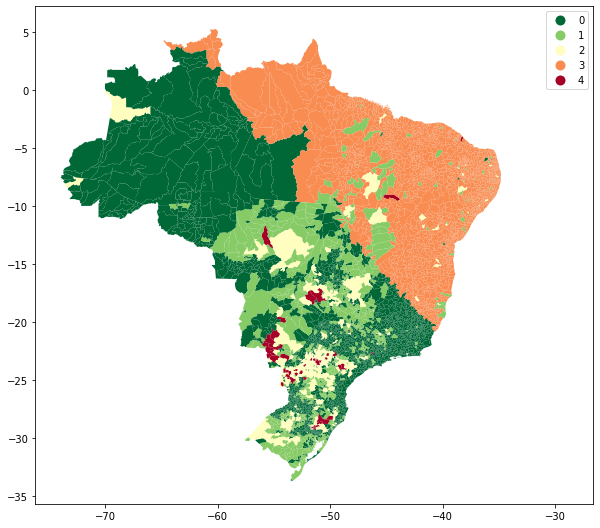

In [57]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

## K-Médias

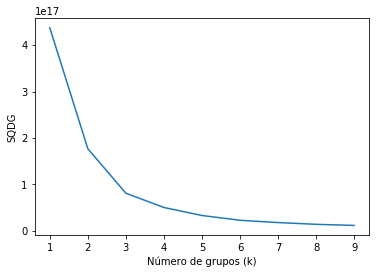

In [58]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dados_centroids.drop(['nome_mun', 'geometry'], axis=1))
    dados_centroids['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure()
plt.plot(list(SQDG.keys()), list(SQDG.values()))
plt.xlabel('Número de grupos (k)')
plt.ylabel('SQDG');

In [59]:
k = 4

In [60]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [61]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
dados_centroids['grupo'] = kmeans.labels_

### Métricas

In [62]:
print(
  round(metrics.calinski_harabasz_score(X, kmeans.labels_),2),
  round(davies_bouldin_score(X, kmeans.labels_),2),
  round(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'),2)  
)

2956.44 0.93 0.47


In [63]:
# contagens
dados_centroids.grupo.value_counts()

2    2863
0    2291
1     361
3      53
Name: grupo, dtype: int64

In [64]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
dados_centroids.groupby('grupo').mean()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,0.666521,1.970111e+05,1.228700e+04,5.358502e+03,1.271754e+04,277.517639,14.820371,0.098210,-41.029570,-8.718557,1.117852
1,97.545706,1.687352e+07,1.209986e+06,5.235051e+05,1.417709e+06,26907.096122,1490.156399,29.631579,-50.921770,-22.536560,3.806094
2,6.039120,1.466599e+06,8.109295e+04,3.418270e+04,4.793908e+04,1491.033084,122.610307,0.808592,-49.749489,-21.755214,1.800559
3,332.018868,6.481863e+07,5.255961e+06,2.244084e+06,6.815201e+06,48075.325472,2286.783585,125.849057,-51.128539,-22.934249,3.415094


In [65]:
# mediana das variáveis para cada grupo
dados_centroids.groupby('grupo').median()

,apolices_contratadas,total_segurado_mil,soma_premio_total_mil,total_subvencao_mil,valor_indenizacoes_pagas_mil,sinistralidade_media,taxa_media,apolices_indenizadas,x_centroid,y_centroid,grupos
grupo,,,,,,,,,,,
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,-40.340720,-7.704281,1
1,81.0,14086469.34,1044391.85,441452.81,1075943.88,24851.00,1449.36,21.0,-51.541310,-23.468766,3
2,1.0,116264.75,4605.47,2026.55,0.00,0.00,17.00,0.0,-49.584976,-21.877408,1
3,317.0,53601520.21,4280000.75,1846939.52,5502523.96,47141.37,1967.18,93.0,-51.552312,-23.514218,4


In [66]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos Centroide K-médias

In [67]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

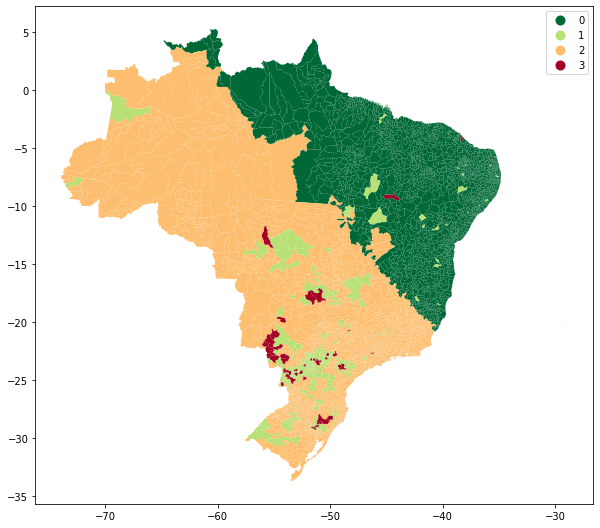

In [68]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

##  Spatially Constrained Hierarchical Clustering - K-Médias

In [69]:
w = Queen.from_dataframe(dados_br)
w.transform = 'r'

In [70]:
model = AgglomerativeClustering(distance_threshold=80, linkage='ward', connectivity=w.sparse,  n_clusters=None)
model.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<5568x5568 sparse matrix of type '<class 'numpy.float64'>'
	with 28004 stored elements in Compressed Sparse Row format>,
                        distance_threshold=80, linkage='ward', memory=None,
                        n_clusters=None)

In [71]:
dados_centroids['grupo'] = model.labels_

In [72]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

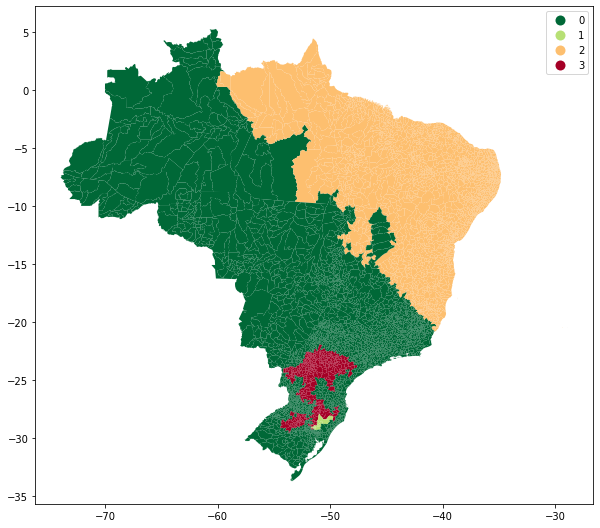

In [73]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'

## Análise de agrupamento - Centroides - Outra distância

In [74]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

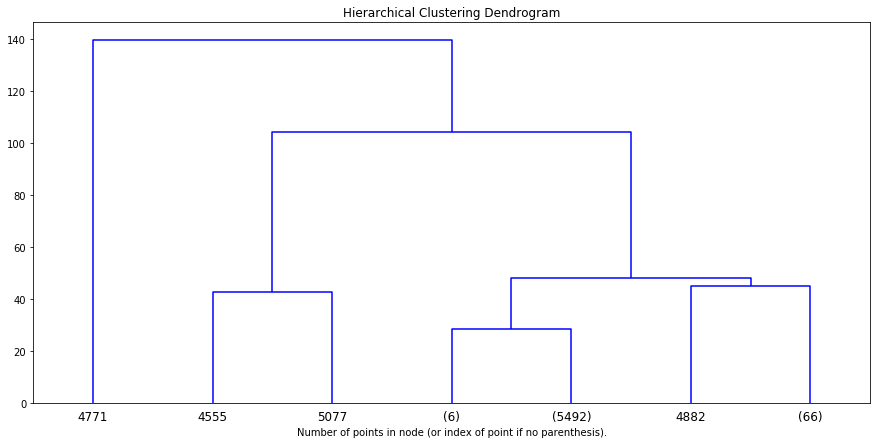

In [77]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=120, n_clusters=None, affinity='manhattan', linkage='average')

model = model.fit(X)
plt.subplots(figsize=(15, 7))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3, color_threshold=0.1)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Métricas

In [78]:
# métricas
print(
  round(metrics.calinski_harabasz_score(X, grupos.ravel()),2),
  round(davies_bouldin_score(X, grupos.ravel()),2),
  round(metrics.silhouette_score(X, grupos.ravel(), metric='euclidean'),2)  
)

2938.9 0.92 0.53


In [79]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
dados_centroids['grupo'] = model.labels_
# moran_matrix.head(2)

In [80]:
# contagem de observações em cada grupo
dados_centroids.grupo.value_counts()

0    5567
1       1
Name: grupo, dtype: int64

### Mapa Grupos Centroides

In [81]:
dados_centroids['grupo'] = dados_centroids['grupo'].astype('category')

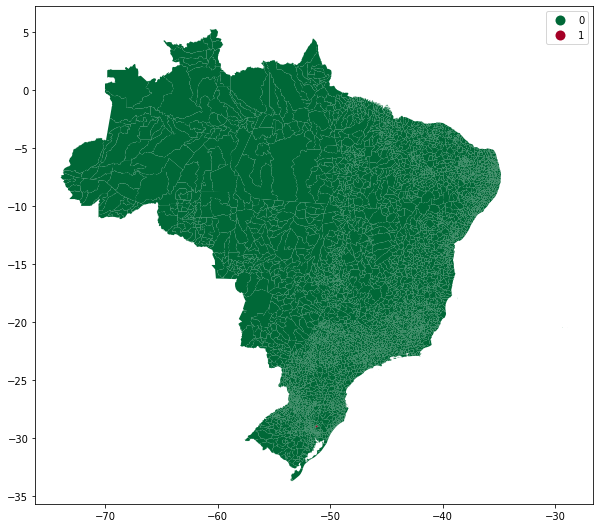

In [82]:
dados_centroids.plot(column='grupo', figsize=(10, 10), legend=True, cmap='RdYlGn_r'); # , cmap='OrRd'